# CIS IEEE UNB - Renting Houce Prices Prediction

O desafio consiste em desenvolver um modelo capaz de prever o preço de imóveis do Rio de Janeiro cadastrados no AirBnB, tendo em vista as características do imóvel fornecidas durante o seu cadastro.


## Objetivos

1. Fazer uma análise do dataset utilizando ferramentas aprendidas no período
2. Demonstrar como pré-processar e representar os diferentes tipos de dados
3. Demonstrar a utilização de técnicas como one-hot encoding, redução de dimensionalidade e PCA;

    i.Como a redução da dimensionalidade afetou no desempenho do modelo?

4. Aplicar regressão nos dados - dividir o dataset em treinamento e
validação e aplicar, pelo menos, 3 algoritmos distintos de regressão para
prever o preço do imóvel. Testar visualizar os resultados, comparando o
desempenho dos modelos treinados;

    i. Qual modelo performou melhor?

5. Avaliar o desempenho do(s) modelo(s) treinado(s). A métrica da
competição será o erro quadrático médio (MSE), porém, recomenda-se a
avaliação do modelo por outras métricas adicionais, como o R2 e o erro
médio absoluto (MAE).

In [84]:
import pandas as pd
import numpy as np

test_path = './data/test.csv'
train_path = './data/train.csv'

test = pd.read_csv(test_path)
train = pd.read_csv(train_path)


/tmp/ipykernel_397375/504526654.py:8: DtypeWarning: Columns (0,21,24,29) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


In [85]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196030 entries, 0 to 196029
Data columns (total 36 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            196030 non-null  int64  
 1   listing_url                                   196030 non-null  object 
 2   scrape_id                                     196030 non-null  float64
 3   last_scraped                                  196030 non-null  object 
 4   name                                          195706 non-null  object 
 5   summary                                       186334 non-null  object 
 6   space                                         118777 non-null  object 
 7   description                                   191715 non-null  object 
 8   experiences_offered                           196030 non-null  object 
 9   neighborhood_overview                         10

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588091 entries, 0 to 588090
Data columns (total 37 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            588091 non-null  object 
 1   listing_url                                   588091 non-null  object 
 2   scrape_id                                     588090 non-null  float64
 3   last_scraped                                  588091 non-null  object 
 4   name                                          586971 non-null  object 
 5   summary                                       558441 non-null  object 
 6   space                                         355819 non-null  object 
 7   description                                   574567 non-null  object 
 8   experiences_offered                           588091 non-null  object 
 9   neighborhood_overview                         31

In [87]:
missing_values = train.isna().sum() / len(train) * 100
print(missing_values)

id                                               0.000000
listing_url                                      0.000000
scrape_id                                        0.000170
last_scraped                                     0.000000
name                                             0.190447
summary                                          5.041737
space                                           39.495928
description                                      2.299644
experiences_offered                              0.000000
neighborhood_overview                           46.108340
minimum_minimum_nights                          23.290613
maximum_minimum_nights                          23.290613
minimum_maximum_nights                          23.290613
maximum_maximum_nights                          23.290613
minimum_nights_avg_ntm                          23.290613
maximum_nights_avg_ntm                          23.290613
number_of_reviews_ltm                           23.290613
calculated_hos

Aqui vemos os casos criticos. 

1. Duas colunas possuem em torno de 40% de valores faltantes
2. 10 colunas possuem a mesma porcentagem de valores faltantes = 23.543845% (MCAR - Missing completely at random)

Vamos abordar da seguinte forma:

1. Excluir as colunas com aproximadamente 20% de valores faltantes
2. Imputar valores faltantes nas outras colunas com a média e moda


Excluir as colunas com aproximadamente 40% de valores faltantes para os dois dataframes.

In [88]:
# Dataframe de treino
for column in train:
    if (train[column].isna().sum() / len(train) * 100) > 20:
        train = train.drop(column,axis=1)

# Data frame de teste
for column in test:
    if (test[column].isna().sum() / len(test) * 100) > 20:
        test = test.drop(column,axis=1)

missing_values = train.isna().sum() / len(train) * 100
print(missing_values)

id                     0.000000
listing_url            0.000000
scrape_id              0.000170
last_scraped           0.000000
name                   0.190447
summary                5.041737
description            2.299644
experiences_offered    0.000000
host_is_superhost      0.049992
host_listings_count    0.049992
latitude               0.000000
longitude              0.000000
accommodates           0.000000
bathrooms              0.191467
bedrooms               0.100665
beds                   0.299103
extra_people           0.000000
minimum_nights         0.000000
number_of_reviews      0.000000
instant_bookable       0.000170
amenities              0.000000
property_type          0.000000
room_type              0.000000
cancellation_policy    0.000170
price                  0.000000
dtype: float64


Para imputar valores as colunas é preciso verificar os tipos de dados de cada uma delas.

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588091 entries, 0 to 588090
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   588091 non-null  object 
 1   listing_url          588091 non-null  object 
 2   scrape_id            588090 non-null  float64
 3   last_scraped         588091 non-null  object 
 4   name                 586971 non-null  object 
 5   summary              558441 non-null  object 
 6   description          574567 non-null  object 
 7   experiences_offered  588091 non-null  object 
 8   host_is_superhost    587797 non-null  object 
 9   host_listings_count  587797 non-null  object 
 10  latitude             588091 non-null  float64
 11  longitude            588091 non-null  float64
 12  accommodates         588091 non-null  object 
 13  bathrooms            586965 non-null  float64
 14  bedrooms             587499 non-null  float64
 15  beds             

### Conversão de tipos

Aqui podemos veriricar certos casos onde o tipo de dado não é ótimo para uma analise de dados:

1. Dados numéricos do tipo object que deveriam ser do tipo float
2. Dados categópricos do tipo object que deveriam ser do tipo float

Alterando erros da coluna id:

In [90]:
train['id'] = range(len(train))
train['id'] = train['id'].astype('int64')

test['id'] = range(len(test))
test['id'] = test['id'].astype('int64')

Alterando tipagem dos dados numericos e corrigindo erros de formatação.

In [91]:
train['price']

0           $229.00
1         $1,502.00
2           $569.00
3           $499.00
4           $132.00
            ...    
588086      $100.00
588087    $1,200.00
588088      $298.00
588089    $7,901.00
588090      $400.00
Name: price, Length: 588091, dtype: object

In [92]:
# Dados categóricos (nominal)
categorical_data = ['host_is_superhost']
numeric_data = ['minimum_nights','latitude','extra_people','longitude','host_listings_count', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews','price','accommodates']

# Dataframe de treino
# Conversão dos dados numéricos
for column in train.columns:
    if column in numeric_data and train[column].dtype == 'object':
        train[column] = train[column].str.replace('[\$,]', '', regex=True)
        train[column] = pd.to_numeric(train[column], errors='coerce')
        # train[column] = train[column].astype(np.float64, copy=False)

# Dataframe de teste
test_numeric_data = ['minimum_nights', 'extra_people', 'host_listings_count', 'accommodates','extra_people']

for column in test.columns:
    if column in test_numeric_data and test[column].dtype == 'object':
        test[column] = test[column].str.replace('[\$,]', '', regex=True)
        test[column] = pd.to_numeric(test[column], errors='coerce')
        test[column] = pd.to_numeric(test[column], errors='coerce')
        


train.info()
train['host_listings_count']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588091 entries, 0 to 588090
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   588091 non-null  int64  
 1   listing_url          588091 non-null  object 
 2   scrape_id            588090 non-null  float64
 3   last_scraped         588091 non-null  object 
 4   name                 586971 non-null  object 
 5   summary              558441 non-null  object 
 6   description          574567 non-null  object 
 7   experiences_offered  588091 non-null  object 
 8   host_is_superhost    587797 non-null  object 
 9   host_listings_count  16376 non-null   float64
 10  latitude             588091 non-null  float64
 11  longitude            588091 non-null  float64
 12  accommodates         16383 non-null   float64
 13  bathrooms            586965 non-null  float64
 14  bedrooms             587499 non-null  float64
 15  beds             

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
588086   NaN
588087   NaN
588088   NaN
588089   NaN
588090   NaN
Name: host_listings_count, Length: 588091, dtype: float64

Podemos verificar agora que os dados numéricos possuem o tipo float.

### Imputação de valores faltantes

Para a imputação de valores faltantes, vamos utilizar a média para os dados numéricos e a moda para os dados categóricos.

In [93]:
# Dataframe de treino
for column in train.columns:
    if train[column].dtype == 'object': # Dados categóricos
        mode_value = train[column].mode()[0]
        train.fillna({column:mode_value}, inplace=True)
    elif train[column].dtype == 'float64': # Dados numéricos
        mean_value = train[column].mean()
        train.fillna({column:mean_value}, inplace=True)

# Dataframe de teste
for column in test.columns:
    if test[column].dtype == 'object': # Dados categóricos
        mode_value = test[column].mode()[0]
        test.fillna({column:mode_value}, inplace=True)
    elif test[column].dtype == 'float64': # Dados numéricos
        mean_value = test[column].mean()
        test.fillna({column:mean_value}, inplace=True)


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588091 entries, 0 to 588090
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   588091 non-null  int64  
 1   listing_url          588091 non-null  object 
 2   scrape_id            588091 non-null  float64
 3   last_scraped         588091 non-null  object 
 4   name                 588091 non-null  object 
 5   summary              588091 non-null  object 
 6   description          588091 non-null  object 
 7   experiences_offered  588091 non-null  object 
 8   host_is_superhost    588091 non-null  object 
 9   host_listings_count  588091 non-null  float64
 10  latitude             588091 non-null  float64
 11  longitude            588091 non-null  float64
 12  accommodates         588091 non-null  float64
 13  bathrooms            588091 non-null  float64
 14  bedrooms             588091 non-null  float64
 15  beds             

Agora podemos verificar que todos os dados possuem a tipagem correta para análise a uma correta imputação desses dos valores faltantes.

### Data Encoding

Para a aplicação de modelos de regressão, é necessário que os dados estejam em formato numérico. Para isso, vamos aplicar a técnica de one-hot encoding para as variáveis categóricas. 

Aqui identificamos algumas colunas que podem ser codificadas para one-hot encoding.

1.  instant_bookable -> t/f
2.  host_is_superhost -> t/f
3.  property_type -> 48 tipos
4.  room_type -> 5 tipos
5.  cancellation_policy -> 6 tipos
6. amenities

Para os dados que possuem valores t/f utilizaremos OneHotEncoder.

Essa técnica é usada para aplicar em dados categóricos nominais. A codificação one-hot converte dados categóricos em uma matriz binária, onde cada categoria é representada por um dígito binário único (0 ou 1). Essa técnica cria uma coluna binária para cada categoria e marca a presença ou ausência dessa categoria com um 1 ou 0, respectivamente.

In [94]:
# OneHot Encoder

# Categorical data 
categoric_data = ['host_is_superhost', 'instant_bookable', 'property_type', 'room_type', 'cancellation_policy']

# Dataframe de treino
# Atribuir t -> 1, f -> 0
for column in ['host_is_superhost', 'instant_bookable']:
    train[column] = train[column].replace({'t': 1, 'f': 0})
    train[column] = train[column].infer_objects(copy=False)
    train[column] = pd.to_numeric(train[column], errors='coerce')

# Dataframe de teste
for column in ['host_is_superhost', 'instant_bookable']:
    test[column] = test[column].replace({'t': 1, 'f': 0})
    test[column] = test[column].infer_objects(copy=False)
    train[column] = pd.to_numeric(train[column], errors='coerce')

train['amenities'].unique()
train.info()


/tmp/ipykernel_397375/3813621825.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[column] = train[column].replace({'t': 1, 'f': 0})
/tmp/ipykernel_397375/3813621825.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[column] = test[column].replace({'t': 1, 'f': 0})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588091 entries, 0 to 588090
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   588091 non-null  int64  
 1   listing_url          588091 non-null  object 
 2   scrape_id            588091 non-null  float64
 3   last_scraped         588091 non-null  object 
 4   name                 588091 non-null  object 
 5   summary              588091 non-null  object 
 6   description          588091 non-null  object 
 7   experiences_offered  588091 non-null  object 
 8   host_is_superhost    588091 non-null  int64  
 9   host_listings_count  588091 non-null  float64
 10  latitude             588091 non-null  float64
 11  longitude            588091 non-null  float64
 12  accommodates         588091 non-null  float64
 13  bathrooms            588091 non-null  float64
 14  bedrooms             588091 non-null  float64
 15  beds             

Para os dados categoricos com mais de 2 tipos, utilizaremos o Label Encoding (codificação de rotúlos).

A codificação de rótulos é uma técnica usada em aprendizado de máquina para converter dados categóricos em formato numérico. Ao contrário da codificação one-hot ou da codificação ordinal, a codificação de rótulos não considera necessariamente qualquer ordem ou hierarquia inerente entre as categorias. Em vez disso, ela atribui um rótulo numérico único a cada categoria, essencialmente convertendo-as em representações numéricas.

In [95]:
#Label Encoding

from sklearn.preprocessing import LabelEncoder

# Data frame de treino
for column in categoric_data[2:]:
    train[column] = LabelEncoder().fit_transform(train[column])

    
# Data frame de teste
for column in categoric_data[2:]:
    test[column] = LabelEncoder().fit_transform(test[column])

train['amenities'].nunique()

93761

### Selecionando colunas e tratando dados da coluna amenities

In [96]:
def normalize_amenities(amenities):
    # Remover caracteres especiais e converter para minúsculas
    amenities = amenities.replace('{', '').replace('}', '').replace('"', '').lower()
    # Remover espaços em branco extras
    amenities = amenities.strip()
    return amenities

# Dataframe de train
# Aplicar a função de normalização
train['amenities'] = train['amenities'].apply(normalize_amenities)

# Dividir a string de amenities em uma lista e contar o número de amenities
train['amenities'] = train['amenities'].str.split(',').apply(len)

# Dataframe de test
test['amenities'] = test['amenities'].apply(normalize_amenities)

# Dividir a string de amenities em uma lista e contar o número de amenities
test['amenities'] = test['amenities'].str.split(',').apply(len)

price_affecting_columns = [
    "id",
    "number_of_reviews",
    "host_is_superhost",
    "host_listings_count",
    "latitude",
    "longitude",
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms",
    "extra_people",
    "minimum_nights",
    "instant_bookable",
    "property_type",
    "room_type",
    "amenities",
    "cancellation_policy",
    "price"
]


train_price = train[price_affecting_columns]
test_price = test[price_affecting_columns[:-1]]

### Eliminando outliers

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

def percentile(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    IQR = q3 - q1
    inf_limit = q1 - (1.5 * IQR)
    sup_limit = q3 + (1.5 * IQR)
    return inf_limit, sup_limit

def eliminate_outliers(df, column_name):
    lines_quantity = df.shape[0]
    inf_limit, sup_limit = percentile(df[column_name])
    df = df.loc[(df[column_name] >= inf_limit) & (df[column_name] <= sup_limit), :]
    removed_lines = lines_quantity - df.shape[0]
    return df, removed_lines

def box_plot(columns): # plotar o box plot (diagrama de caixa)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8.9, 3)
    sns.boxplot(x=columns, ax=ax1)
    ax2.set_xlim(percentile(columns))
    sns.boxplot(x=columns, ax=ax2)

    ax1.title.set_text('Com outliers')
    ax2.title.set_text('Sem outliers')

total_removed_lines = 0
cols = ['beds', 'number_of_reviews', 'price', 'extra_people', 'bathrooms', 
                      'bedrooms', 'minimum_nights', 'host_listings_count', 'accommodates']
for column in cols:
    train_price, removed_lines = eliminate_outliers(train_price, column)
    total_removed_lines += removed_lines

print(f'Foram removidas {total_removed_lines} linhas')
print(train_price.isna().sum())

Foram removidas 200492 linhas
id                     0
number_of_reviews      0
host_is_superhost      0
host_listings_count    0
latitude               0
longitude              0
accommodates           0
bedrooms               0
beds                   0
bathrooms              0
extra_people           0
minimum_nights         0
instant_bookable       0
property_type          0
room_type              0
amenities              0
cancellation_policy    0
price                  0
dtype: int64


### Tratando a coluna ammenities

Devido a grande quantidade de valores em ammenities, precisamos normalizar os dados dessa coluna.

In [98]:
train_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387599 entries, 0 to 588090
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   387599 non-null  int64  
 1   number_of_reviews    387599 non-null  float64
 2   host_is_superhost    387599 non-null  int64  
 3   host_listings_count  387599 non-null  float64
 4   latitude             387599 non-null  float64
 5   longitude            387599 non-null  float64
 6   accommodates         387599 non-null  float64
 7   bedrooms             387599 non-null  float64
 8   beds                 387599 non-null  float64
 9   bathrooms            387599 non-null  float64
 10  extra_people         387599 non-null  float64
 11  minimum_nights       387599 non-null  float64
 12  instant_bookable     387599 non-null  int64  
 13  property_type        387599 non-null  int64  
 14  room_type            387599 non-null  int64  
 15  amenities            3

In [99]:
test_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196030 entries, 0 to 196029
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   196030 non-null  int64  
 1   number_of_reviews    196030 non-null  float64
 2   host_is_superhost    196030 non-null  int64  
 3   host_listings_count  196030 non-null  float64
 4   latitude             196030 non-null  float64
 5   longitude            196030 non-null  float64
 6   accommodates         196030 non-null  int64  
 7   bedrooms             196030 non-null  float64
 8   beds                 196030 non-null  float64
 9   bathrooms            196030 non-null  float64
 10  extra_people         196030 non-null  float64
 11  minimum_nights       196030 non-null  int64  
 12  instant_bookable     196030 non-null  int64  
 13  property_type        196030 non-null  int64  
 14  room_type            196030 non-null  int64  
 15  amenities        

In [100]:
test_price.head()

,id,number_of_reviews,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,bathrooms,extra_people,minimum_nights,instant_bookable,property_type,room_type,amenities,cancellation_policy
0,0,213.0,0,2.0,-22.965919,-43.178962,5,2.0,2.0,1.0,58.0,4,1,14,0,25,3
1,1,214.0,0,3.0,-22.977117,-43.190454,3,1.0,2.0,1.0,45.0,4,0,1,0,14,3
2,2,1.0,0,3.0,-22.921990,-43.183836,3,0.0,2.0,1.0,0.0,3,0,1,0,14,3
3,3,13.0,1,1.0,-22.983593,-43.193819,1,1.0,1.0,1.0,0.0,3,1,1,2,44,3
4,4,100.0,0,2.0,-22.981082,-43.190776,2,0.0,2.0,1.0,100.0,3,1,1,0,45,3


### Aplicar regressão nos dados

In [101]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression



sample_size = 200000
train_sampled = train_price.sample(n=sample_size, random_state=64)

x = train_sampled.drop('price', axis=1).values
y = train_sampled['price'].values




/home/caefleury/Documents/unb/trainee-cis-ieee/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Resultados para arvore_decisao:
Mean Squared Error: 13921.5964
Mean Absolute Error: 38.9745
R2 Score: 0.8453609844131185

Previsões para arvore_decisao no conjunto de teste:
[101. 151. 101. 184. 100. 548. 298. 261. 199. 109.]

Arquivo CSV gerado para arvore_decisao: arvore_decisao_predictions.csv


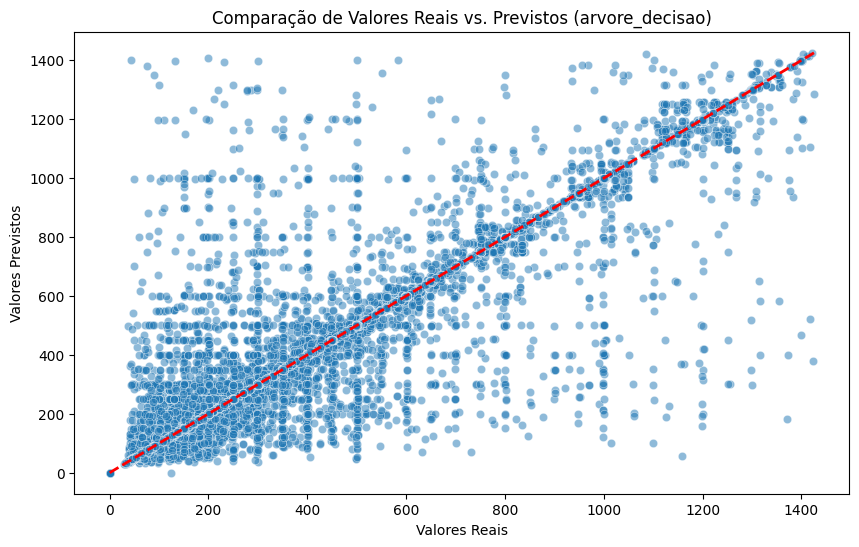

In [107]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=64)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(test_price)

models = {
    'arvore_decisao': DecisionTreeRegressor(),
}

def train_and_evaluate(models, x_train, x_val, y_train, y_val):
    results = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred_val = model.predict(x_val)
        mse = mean_squared_error(y_val, y_pred_val)
        mae = mean_absolute_error(y_val, y_pred_val)
        r2 = r2_score(y_val, y_pred_val)
        results[name] = {
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        }
    return results


results = train_and_evaluate(models, x_train_scaled, x_val_scaled, y_train, y_val)


test_predictions = {}
for name, model in models.items():
    test_predictions[name] = model.predict(x_test_scaled)

for model_name, metrics in results.items():
    print(f"Resultados para {model_name}:")
    print(f"Mean Squared Error: {metrics['MSE']}")
    print(f"Mean Absolute Error: {metrics['MAE']}")
    print(f"R2 Score: {metrics['R2']}")
    print()

def plot_comparison(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title(f'Comparação de Valores Reais vs. Previstos ({model_name})')
    plt.show()

for model_name, model in models.items():
    y_pred_val = model.predict(x_val_scaled)
    plot_comparison(y_val, y_pred_val, model_name)


### Extraindo o arquivo csv

In [109]:
for model_name, y_pred in test_predictions.items():
    print(f"Previsões para {model_name} no conjunto de teste:")
    print(y_pred[:10])
    print()
    test_df = test_price.copy()
    test_df['id'] = range(len(test_df))
    results_df = pd.DataFrame({
    'ID': test_df['id'],
    'price': y_pred
    })
    results_df = results_df.sort_values(by='ID').reset_index(drop=True)
    results_df.to_csv(f"airbnb_predictions.csv", index=False)
    print(f"Arquivo CSV gerado para airbnb: airbnb_predictions.csv")

Previsões para arvore_decisao no conjunto de teste:
[101. 151. 101. 184. 100. 548. 298. 261. 199. 109.]

Arquivo CSV gerado para hello: hello_predictions.csv


### Respostas


1. Fazer uma análise do dataset utilizando ferramentas aprendidas no período
2. Demonstrar como pré-processar e representar os diferentes tipos de dados
3. Demonstrar a utilização de técnicas como one-hot encoding, redução de dimensionalidade e PCA;

    i.Como a redução da dimensionalidade afetou no desempenho do modelo?

4. Aplicar regressão nos dados - dividir o dataset em treinamento e
validação e aplicar, pelo menos, 3 algoritmos distintos de regressão para
prever o preço do imóvel. Testar visualizar os resultados, comparando o
desempenho dos modelos treinados;

    i. Qual modelo performou melhor?

5. Avaliar o desempenho do(s) modelo(s) treinado(s). A métrica da
competição será o erro quadrático médio (MSE), porém, recomenda-se a
avaliação do modelo por outras métricas adicionais, como o R2 e o erro
médio absoluto (MAE).